In [72]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras import datasets, layers, models, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GlobalAveragePooling2D,Dense, BatchNormalization, Dropout, Flatten, Conv2D, MaxPooling2D,Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import numpy as np
import pandas as pd
import random
import os
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns

import math
import PIL
import random
import sys


In [4]:
import warnings
warnings.filterwarnings("ignore")

In [11]:
# dictionaries for each training, validation, testing sets
dict_train = {}
dict_valid = {}
dict_test = {}

path = '.../Projects/Food11'

# Make dictionary storing images for each category under train data.
path_train = os.path.join(path, "training")
for i in os.listdir(path_train):
    dict_train[i] = os.listdir(os.path.join(path_train, i))

    
# Make dictionary storing images for each category under train data and split into validation data.
path_valid = os.path.join(path, "validation")
for i in os.listdir(path_valid):
    dict_valid[i] = os.listdir(os.path.join(path_valid, i))

# Make dictionary storing images for each category under test data.
path_test = os.path.join(path, "evaluation")
for i in os.listdir(path_test):
    dict_test[i] = os.listdir(os.path.join(path_test, i))


val_loss = list()
val_accuracy = list()
test_loss= list()
test_accuracy = list()

In [12]:
# convert dictionary values into arrays
train_len = np.concatenate(list(dict_train.values())).shape[0]
valid_len = np.concatenate(list(dict_valid.values())).shape[0]
test_len = np.concatenate(list(dict_test.values())).shape[0]

print('Number of Training Images: ', train_len)
print('Number of Validation Images: ', valid_len)
print('Number of Test Images: ', test_len)

Number of Training Images:  9866
Number of Validation Images:  3430
Number of Test Images:  3347


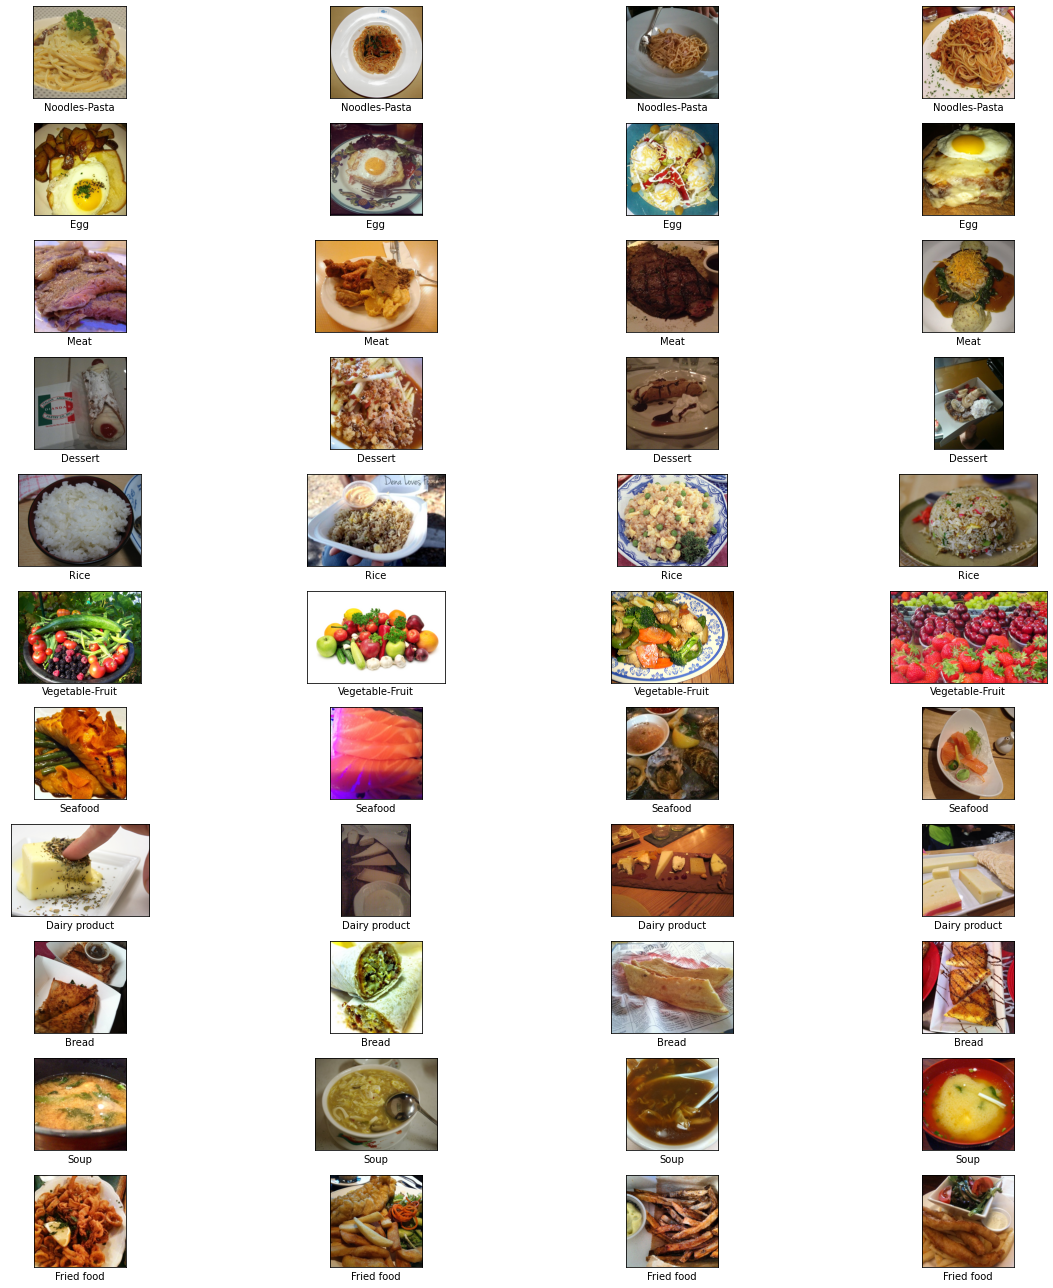

In [16]:
# get class names
class_names = os.listdir(path_train)

# 
fig, axes = plt.subplots(len(dict_train.keys()), 4, figsize = (18,18))
for i, item in enumerate(class_names):
    images = random.sample(dict_train[item], 4)
   
    for j, image in enumerate(images):
        img = PIL.Image.open(os.path.join(path_train, item, image))
        axes[i, j].imshow(img)
        axes[i, j].set(xlabel = item, xticks = [], yticks = [])

fig.tight_layout()

Noodles-Pasta :  440
Egg :  986
Meat :  1325
Dessert :  1500
Rice :  280
Vegetable-Fruit :  709
Seafood :  855
Dairy product :  429
Bread :  994
Soup :  1500
Fried food :  848


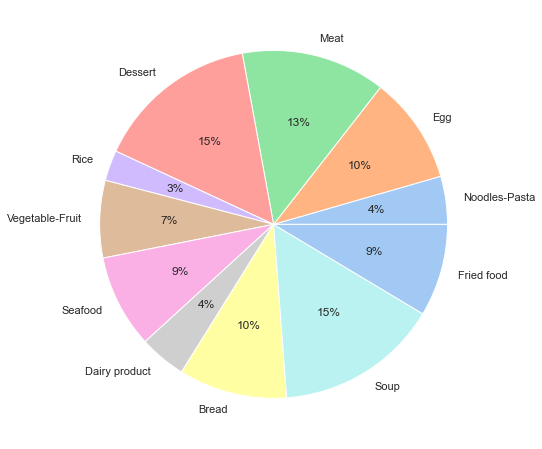

In [18]:
# Create pie chart to understand food-class distribution
counts = []
for item in class_names:
    count = len(dict_train[item])
    counts.append(count)
    print(item, ": ", count)

sns.set(rc={'figure.figsize':(8,8)})
plt.pie(counts, labels = class_names, colors = sns.color_palette('pastel')[0:11], autopct='%.0f%%')
plt.show()

#### Data Augmentation & Database Generation

In [27]:
# Data Augmentation for Training, Validation, and Testing with ImageDataGenerator
train_gen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'nearest',
    rescale=1./255,
    validation_split = 0.2
)

val_gen = ImageDataGenerator(
    rescale=1./255, 
    validation_split = 0.2)

# For test data we only rescale the data. Never augment test data (for obvious reasons)
test_gen = ImageDataGenerator(rescale=1./255)


In [51]:
# Generate data directly from file path with set target_size, batch_size, etc.

BATCH_SIZE = 32

train_generator = train_gen.flow_from_directory(path_train, target_size = (256,256), 
                                                     shuffle = True,
                                                     class_mode = 'categorical', 
                                                     batch_size = BATCH_SIZE, 
                                                     subset = "training")

valid_generator = val_gen.flow_from_directory(path_valid, target_size = (256,256),
                                             shuffle = True, 
                                             class_mode = 'categorical',
                                             batch_size = BATCH_SIZE,
                                             subset = 'validation')

test_generator = test_gen.flow_from_directory(path_test, target_size = (256, 256),
                                             shuffle = False,
                                             class_mode = 'categorical',
                                             batch_size = BATCH_SIZE)

Found 7896 images belonging to 11 classes.
Found 682 images belonging to 11 classes.
Found 3347 images belonging to 11 classes.


#### Transfer Learn Model

In [53]:
# Using transfer learn, chose InceptionResNetV2
# 1,000,000+ trained images, 164 layers, 1000 classes
base_model = InceptionResNetV2(weights = 'imagenet',
                              include_top = False,
                              input_shape = (256, 256, 3))

In [54]:
# Freeze base layers as to not change the weights
base_model.trainable = False

In [55]:
# Add poooling, dense, and dropout layers
# Dropout layers to help prevent overfitting, Dense layers to narrow down to 11 food classes

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
model = tf.keras.Sequential([base_model,
                             global_average_layer,
                             Dense(256, activation = 'relu'),
                             Dropout(0.2),
                             Dense(128, activation = 'relu'),
                             Dropout(0.2),
                             Dense(11, activation = 'softmax')])

In [56]:
# Compiling model with low learning rate
base_learning_rate = 0.0001

model.compile(optimizer = Adam(lr = base_learning_rate),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [59]:
# EarlyStopping and ModelCheckpoint callbacks to keep track with model performance

EPOCHS = 5
es = EarlyStopping(monitor = 'loss',
                  mode = 'min',
                  verbose = 1,
                  patience = 20)

mc = ModelCheckpoint(filepath = 'best_model_res.h5',
                     monitor = 'loss',
                    verbose = 1,
                    save_best_only = True)

history = model.fit(train_generator,
                    steps_per_epoch = train_generator.samples // BATCH_SIZE,
                    epochs = EPOCHS,
                    callbacks = [es, mc],
                    verbose = 1,
                    validation_steps = valid_generator.samples // BATCH_SIZE)

2022-03-11 00:04:09.057132: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-03-11 00:04:09.090628: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/5


2022-03-11 00:04:11.438841: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


246/246 [==============================] - 251s 999ms/step - loss: 1.4889 - accuracy: 0.5257

Epoch 00001: loss improved from inf to 1.48892, saving model to best_model_res.h5
Epoch 2/5
246/246 [==============================] - 212s 849ms/step - loss: 0.9717 - accuracy: 0.6901

Epoch 00002: loss improved from 1.48892 to 0.97168, saving model to best_model_res.h5
Epoch 3/5
246/246 [==============================] - 200s 812ms/step - loss: 0.8369 - accuracy: 0.7291

Epoch 00003: loss improved from 0.97168 to 0.83694, saving model to best_model_res.h5
Epoch 4/5
246/246 [==============================] - 460s 2s/step - loss: 0.7756 - accuracy: 0.7428

Epoch 00004: loss improved from 0.83694 to 0.77555, saving model to best_model_res.h5
Epoch 5/5
246/246 [==============================] - 603s 2s/step - loss: 0.7192 - accuracy: 0.7644

Epoch 00005: loss improved from 0.77555 to 0.71919, saving model to best_model_res.h5


In [62]:
# Evaluating the model with the validation_generator

validation = model.evaluate_generator(valid_generator)
testing = model.evaluate_generator(test_generator)

In [64]:
# Comparing validation and test loss and accuracy
val_loss.append(validation[0])
val_accuracy.append(validation[1])

print('Val loss:', validation[0])
print('Val accuracy:', validation[1])

test_loss.append(testing[0])
test_accuracy.append(testing[1])

print('Test loss:', testing[0])
print('Test accuracy:', testing[1])

# Low losses and high accuracy, model is performing well

Val loss: 0.5879049897193909
Val accuracy: 0.8167155385017395
Test loss: 0.5127318501472473
Test accuracy: 0.8353750109672546


In [66]:
# Predict using testing_generator
y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(y_pred, axis = 1)

2022-03-11 16:53:45.182197: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [74]:
import itertools

# Plot the confusion matrix. Set Normalize = True/False
# Code from kaggle transfer learning classification model
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [89]:
# generate confusion matrix
conf_matrix = confusion_matrix(test_generator.classes, y_pred)

# HeatMap-style confusion matrix plot
plot_confusion_matrix(conf_matrix, classes, normalize = False, title = 'Classes Confusion Matrix')
print(classification_report(test_generator.classes, y_pred, target_names = classes))

In [80]:
labels = {
    0 : 'Bread',
    1 : 'Dairy Product',
    2 : 'Dessert',
    3 : 'Egg',
    4 : 'Fried food',
    5 : 'Meat',
    6 : 'Noddles-Pasta',
    7 : 'Rice',
    8 : 'Seafood',
    9 : 'Soup',
    10 : 'Vegetable-Fruit'
}

In [87]:
# Loading images and their predictions into lists
prediction = []
original = []
image = []
count = 0
for i in os.listdir(path_test):
    for item in os.listdir(os.path.join(path_test, i)):
        #code to open the image
        img= PIL.Image.open(os.path.join(path_test, i, item))
        #resizing the image to (256,256)
        img = img.resize((256,256))
        #appending image to the image list
        image.append(img)
        #converting image to array
        img = np.asarray(img, dtype= np.float32)
        #normalizing the image
        img = img / 255
        #reshaping the image in to a 4D array
        img = img.reshape(-1,256,256,3)
        #making prediction of the model
        predict = model.predict(img)
        #getting the index corresponding to the highest value in the prediction
        predict = np.argmax(predict)
        #appending the predicted class to the list
        prediction.append(labels[predict])
        #appending original class to the list
        original.append(i)


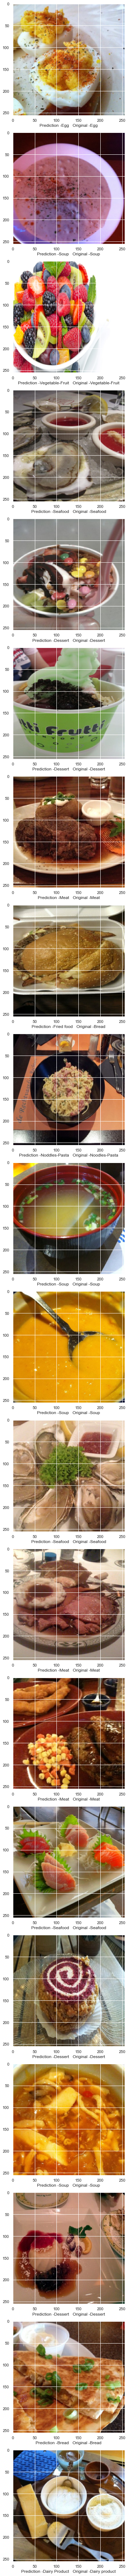

In [88]:
# Printing 20 images, showing the original image classification and predicted image classification
fig=plt.figure(figsize = (100,100))
for i in range(20):
    j = random.randint(0,len(image))
    fig.add_subplot(20,1,i+1)
    plt.xlabel("Prediction -" + prediction[j] +"   Original -" + original[j])
    plt.imshow(image[j])
fig.tight_layout()
plt.show()